In [ ]:
# Add extra imports if needed
!pip install datasets
!pip install evaluate
!pip install wand

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
import os

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset, DatasetDict, Dataset
import numpy as np
import evaluate


In [ ]:
# Use basic BERT.
model_path = "google-bert/bert-base-uncased"

# Load dataset.
dataset_dict = load_dataset("NotShrirang/email-spam-filter")

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "ham", 1: "spam"}
label2id = {"spam": 0, "ham": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# Unfreeze pooler and last BERT feedforward layer in each encoder.
# The BertPooler is usually not enough as we need to learn more on the contextual data gathered by the attention layers
# to know whether we label an email as a spam or not. Most examples that the original BERT model gets wrong
# are a bit more complicated, and the context processing does matter more.
unfreeze_patterns = (
    "pooler",
    #"6.output.dense.weight",
    #"7.output.dense.weight",
    #"8.output.dense.weight",
    #"9.output.dense.weight",
    #"10.output.dense.weight",
    "11.output.dense.weight",
    "11.output.dense.bias",
    #"encoder.layer.11.attention",
   # "encoder.layer.10.attention",
)

for name, param in model.base_model.named_parameters():
    if any(pat in name for pat in unfreeze_patterns):
        param.requires_grad = True

unfrozen = [
    (name, param.shape, param.numel())
    for name, param in model.named_parameters()
    if param.requires_grad
]

for name, param in model.named_parameters():
    #print(name)
    if param.requires_grad:
        print(
            f"{name:60}  "
            f"shape={tuple(param.shape)}  "
            f"params={param.numel():,}"
        )

bert.encoder.layer.11.output.dense.weight                     shape=(768, 3072)  params=2,359,296
bert.encoder.layer.11.output.dense.bias                       shape=(768,)  params=768
bert.pooler.dense.weight                                      shape=(768, 768)  params=589,824
bert.pooler.dense.bias                                        shape=(768,)  params=768
classifier.weight                                             shape=(2, 768)  params=1,536
classifier.bias                                               shape=(2,)  params=2


In [ ]:
def preprocess_function(examples):
    #print(examples["text"])
    return tokenizer(examples["text"], truncation=True)

# preprocess all datasets
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

#print(tokenized_data['train']['input_ids'])
#print(tokenized_data['train']['token_type_ids'])
print(tokenized_data)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'text', 'label_num', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5171
    })
})


In [ ]:
# Use automatic padding.
data_collator = DataCollatorWithPadding(tokenizer)

# Split off 20% as temp, then half that for val/test
full_train = tokenized_data["train"]
split_1    = full_train.train_test_split(test_size=0.20, seed=42)
train_ds   = split_1["train"]
temp_ds    = split_1["test"]

split_2       = temp_ds.train_test_split(test_size=0.50, seed=42)
validation_ds = split_2["train"]
test_ds       = split_2["test"]

dataset_splits = DatasetDict({
    "train":      train_ds,
    "validation": validation_ds,
    "test":       test_ds
})

def preprocess_fn(examples):
    tok = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    # We need to rename this to match 'labels' what BERT expects
    tok["labels"] = examples["label_num"]
    return tok

# Dropping everything but the model inputs + 'labels'
tokenized_splits = dataset_splits.map(
    preprocess_fn,
    batched=True,
    remove_columns=["Unnamed: 0", "text", "label", "label_num"]
)

print(tokenized_splits)

Map:   0%|          | 0/4136 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4136
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 517
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 518
    })
})


In [ ]:
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1,
                                                                 keepdims=True)

    positive_class_probs = probabilities[:, 1]

    auc = np.round(auc_score.compute(prediction_scores=positive_class_probs,
                                     references=labels)['roc_auc'],3)


    predicted_classes = np.argmax(predictions, axis=1)

    acc = np.round(accuracy.compute(predictions=predicted_classes,
                                     references=labels)['accuracy'],3)

    precision = precision_metric.compute(
        predictions=predicted_classes, references=labels
    )["precision"]
    recall = recall_metric.compute(
        predictions=predicted_classes, references=labels
    )["recall"]
    f1 = f1_metric.compute(
        predictions=predicted_classes, references=labels
    )["f1"]

    return {"Accuracy": acc, "AUC": auc, "Precision": precision, "Recall": recall, "F1": f1}

In [ ]:
from transformers import SchedulerType

# hyperparameters
lr = 5e-5
batch_size = 16
num_epochs = 8

training_args = TrainingArguments(
    learning_rate=lr,
    warmup_ratio=0.05, # we want to warm up the model first despite not having a large sample
    lr_scheduler_type=SchedulerType.COSINE, # cosine decline after warmup
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="steps",
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    max_grad_norm=1,
    load_best_model_at_end=True,
)

!pip install wand
os.environ["WANDB_DISABLED"] = "true"

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback, TrainerState, TrainerControl
import torch

class LoggedGradNormCallback(TrainerCallback):
    def on_after_backward(self, args, state, control, model=None, **kwargs):
        total_norm = sum((p.grad.data.norm(2).item()**2 for p in model.parameters() if p.grad is not None))**0.5
        control.should_log = True
        return {"grad_norm": total_norm}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "grad_norm" in logs:
            print(f"[step {state.global_step:4d}] grad norm = {logs['grad_norm']:.2e}")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_splits["train"],
    eval_dataset=tokenized_splits["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    #callbacks=[LoggedGradNormCallback()]
)

trainer.train()

In [ ]:
# apply model to validation dataset
predictions = trainer.predict(tokenized_splits["test"])

# Extract the logits and labels from the predictions object
logits = predictions.predictions
labels = predictions.label_ids

# Use your compute_metrics function
metrics = compute_metrics((logits, labels))
print(metrics)

Epoch,Training Loss,Validation Loss,Accuracy,Auc,Precision,Recall,F1
1,0.028500,0.095808,0.967000,0.995000,0.978417,0.906667,0.941176
2,0.319900,0.091657,0.973000,0.995000,0.972222,0.933333,0.952381
3,0.001000,0.102944,0.965000,0.996000,0.992537,0.886667,0.936620
4,0.001500,0.092740,0.969000,0.995000,0.978571,0.913333,0.944828
5,0.014100,0.092267,0.971000,0.996000,0.978723,0.920000,0.948454
6,0.000700,0.084684,0.971000,0.996000,0.965517,0.933333,0.949153


{'Accuracy': np.float64(0.985), 'AUC': np.float64(0.999), 'Precision': 0.9811320754716981, 'Recall': 0.968944099378882, 'F1': 0.975}


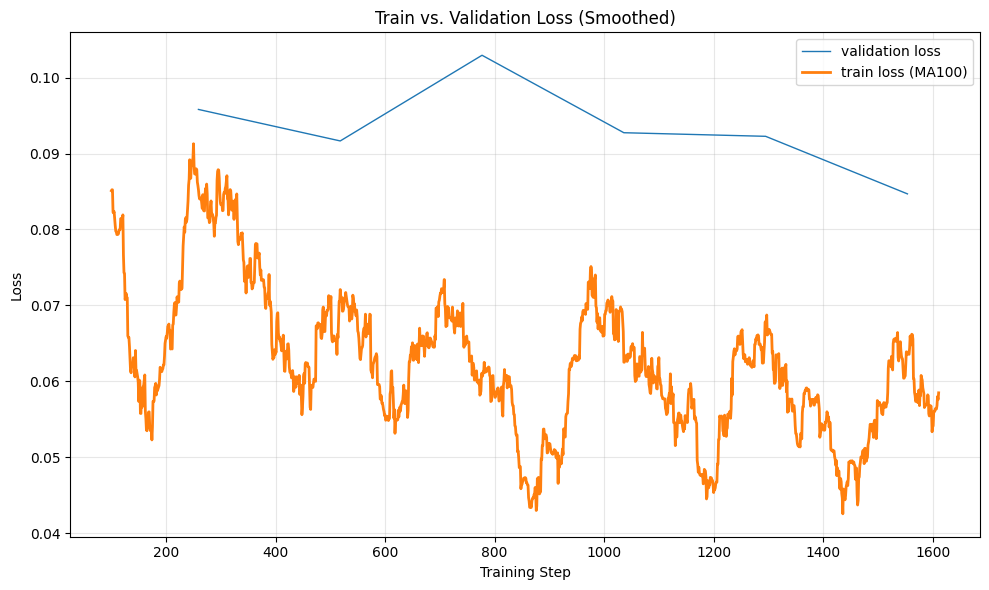

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_steps = [x["step"] for x in history if "loss" in x]
train_losses = [x["loss"] for x in history if "loss" in x]

eval_steps = [x["step"] for x in history if "eval_loss" in x]
eval_losses = [x["eval_loss"] for x in history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
plt.grid(alpha=0.3)

plt.plot(eval_steps, eval_losses, label="validation loss", linewidth=1)

window = 100  # adjust to taste
smoothed = np.convolve(train_losses, np.ones(window)/window, mode='valid')
steps_smoothed = train_steps[window-1:]

plt.plot(steps_smoothed, smoothed, label=f"train loss (MA{window})", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss (Smoothed)")
plt.legend()
plt.tight_layout()
plt.show()
